# Necassary Imports

In [33]:
# Imports
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import re
#import inflect
#from num2words import num2words
from nltk.corpus import stopwords
from collections import Counter

import sklearn

from gensim.models import Word2Vec

from sklearn.model_selection import ParameterSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV

from nltk.stem import WordNetLemmatizer
import nltk 


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\netha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\netha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\netha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Necassary preprocessing steps

In [34]:
# Import data
df = pd.read_csv('us_equities_news_dataset.csv')

In [35]:
# Filter out Nvidia articles
nvidia_df = df[df['title'].str.contains('NVIDIA|NVDA', case=False, na=False) |
               df['content'].str.contains('NVIDIA|NVDA', case=False, na=False) |
               df['ticker'].str.contains('NVIDIA|NVDA', case=False, na=False)]

In [36]:
print(len(nvidia_df))

3464


In [37]:
#Pre processing steps
def preprocess_text_iteration1(text):
    text = text.strip()
    # Replace URLs with an empty string
    re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    words = word_tokenize(text.lower())
    #check if the word is alpha numeric
    alpha_words = [word for word in words if word.isalpha()]
    #remove numbers
    numbers_words = [word for word in alpha_words if not word.isdigit()]
    #stop words removal
    stop_words = set(stopwords.words('english'))
    stop_words_removed = [word for word in numbers_words if not word in stop_words]
    #add lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stop_words_removed]

    return lemmatized_words

# apply preprocessing

# include title in "content"
nvidia_df['content'] = nvidia_df['title'] + ' ' + nvidia_df['content']
nvidia_df['content'] = nvidia_df['content'].apply(preprocess_text_iteration1)

## Remove words that appear too frequently or too infrequently
# Count the frequency of each word
all_words = [word for content in nvidia_df['content'] for word in content]
word_freq = Counter(all_words)

# Define thresholds (play around with these)
min_freq = 5
max_freq = 0.7 * len(nvidia_df)

# Filter words based on frequency
filtered_words = {word for word, freq in word_freq.items() if min_freq <= freq <= max_freq}

# Update the DataFrame with filtered words
def filter_content(content):
    return [word for word in content if word in filtered_words]


nvidia_df['content'] = nvidia_df['content'].apply(filter_content)


In [38]:
#create a document term matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(nvidia_df['content'].apply(lambda x: ' '.join(x)))
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## LDA

[['point', 'percent', 'close', 'trading', 'fell', 'rose', 'dow', 'oil', 'future', 'friday'], ['current', 'portfolio', 'past', 'performance', 'today', 'security', 'value', 'firm', 'return', 'eps'], ['fiscal', 'reported', 'cent', 'positive', 'solution', 'cloud', 'demand', 'margin', 'corporation', 'gaap'], ['etf', 'fund', 'traded', 'past', 'read', 'holding', 'volume', 'exposure', 'since', 'global'], ['driving', 'car', 'google', 'self', 'ai', 'vehicle', 'amazon', 'facebook', 'autonomous', 'device']]
Topic 0: point percent close trading fell rose dow oil future friday
Topic 1: current portfolio past performance today security value firm return eps
Topic 2: fiscal reported cent positive solution cloud demand margin corporation gaap
Topic 3: etf fund traded past read holding volume exposure since global
Topic 4: driving car google self ai vehicle amazon facebook autonomous device
[[9.97010036e-01 7.46315347e-04 7.47834787e-04 7.55076533e-04
  7.40737759e-04]
 [7.83877570e-01 6.62076775e-02 9.

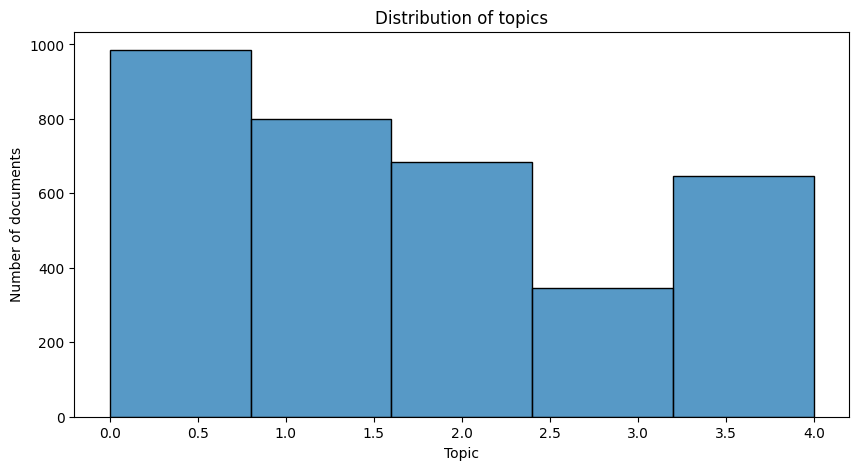

In [39]:
# train LDAModel
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, random_state=0) #once I can run zeroth it, change n_components to something else
lda.fit(X)

# get topics
def get_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    topics = []
    for topic in model.components_:
        topic_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(topic_words)
    return topics

topics = get_topics(lda, vectorizer, 10)
print(topics)
for i, topic in enumerate(topics):
    print('Topic {}: {}'.format(i, ' '.join(topic)))


# get topic distribution for each document
topic_dist = lda.transform(X)
print(topic_dist)

# plot the distribution of topics
plt.figure(figsize=(10, 5))
sns.histplot(topic_dist.argmax(axis=1), bins=5)
plt.xlabel('Topic')
plt.ylabel('Number of documents')
plt.title('Distribution of topics')
plt.show()



In [40]:
# create a cluster plot for the topics

#if we have more time we look this because it is a cool plot (we don't fully understand it because copilot made it)

# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=0)
# tsne_embedding = tsne.fit_transform(topic_dist)
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=tsne_embedding[:, 0], y=tsne_embedding[:, 1], hue=topic_dist.argmax(axis=1), palette='tab10')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# plt.title('t-SNE plot of topics')
# plt.show()

## FLSA-W

In [41]:
# FuzzyTM FLSA-W
from FuzzyTM import FLSA_W

# Coherence and Diversity



In [42]:


# create a FLSA-W model (based on the previous iteration, we can conclude that 5 topics is best)
# We continue with 5 topics since we notice the coherence is highest, and the diversity is also good (but not the highest)
flsaW = FLSA_W(
input_file = nvidia_df['content'].to_list(),
num_topics=5,
num_words=10,
)

In [43]:
flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL
print(flsaW.show_topics())


[(0, '0.0182*"generation" + 0.0161*"margin" + 0.0156*"expect" + 0.0144*"executive" + 0.0143*"gross" + 0.0142*"know" + 0.0136*"half" + 0.0135*"think" + 0.013*"chief" + 0.013*"server"'), (1, '0.0004*"premarket" + 0.0003*"unveils" + 0.0003*"smh" + 0.0003*"uncover" + 0.0003*"conclusively" + 0.0003*"esp" + 0.0003*"avoided" + 0.0003*"soxx" + 0.0003*"strategiesit" + 0.0003*"delve"'), (2, '0.0006*"inbox" + 0.0005*"previously" + 0.0005*"phlx" + 0.0005*"amat" + 0.0005*"ratio" + 0.0005*"contract" + 0.0005*"ltd" + 0.0005*"advancing" + 0.0005*"bac" + 0.0005*"gmt"'), (3, '0.0033*"compared" + 0.0033*"adoption" + 0.0032*"gaming" + 0.0031*"basis" + 0.0031*"computing" + 0.0029*"ago" + 0.0028*"segment" + 0.0028*"believe" + 0.0027*"significant" + 0.0027*"fourth"'), (4, '0.0017*"corporation" + 0.0016*"investing" + 0.0015*"corp" + 0.0015*"gained" + 0.0015*"com" + 0.0014*"surged" + 0.0014*"released" + 0.0014*"point" + 0.0013*"added" + 0.0013*"boost"')]


## Compute Diversity, Coherence, Interpretability for FLSA-W and LDA

In [44]:
for topic in flsaW.show_topics(representation='words'):
    print(topic)


print(flsaW.get_coherence_score()) # ask if this has to be high
print(flsaW.get_diversity_score()) # ask if this has to be high
print(flsaW.get_interpretability_score()) # ask if this has to be high




['generation', 'margin', 'expect', 'executive', 'gross', 'know', 'half', 'think', 'chief', 'server']
['premarket', 'unveils', 'smh', 'uncover', 'conclusively', 'esp', 'avoided', 'soxx', 'strategiesit', 'delve']
['inbox', 'previously', 'phlx', 'amat', 'ratio', 'contract', 'ltd', 'advancing', 'bac', 'gmt']
['compared', 'adoption', 'gaming', 'basis', 'computing', 'ago', 'segment', 'believe', 'significant', 'fourth']
['corporation', 'investing', 'corp', 'gained', 'com', 'surged', 'released', 'point', 'added', 'boost']
0.4475928121437868
1.0
0.4475928121437868


In [45]:
#coherence for lda (we make sure tha the content is the same as the content used to train FLSA-W and LDA)
coherence_lda = flsaW.get_coherence_score(
nvidia_df['content'].to_list(),
topics)

print(coherence_lda)

0.5988575134254617


In [46]:
#diversity for lda (we make sure tha the content is the same as the content used to train FLSA-W and LDA)
diversity_lda = flsaW.get_diversity_score(topics)
print(diversity_lda)

0.98


In [47]:
#lda interpretability
interpretability_lda = diversity_lda * coherence_lda
print(interpretability_lda)

0.5868803631569525


## Elbow plots (FLSA-W and LDA)

1
2
3
4
5
6
7
8
9
10


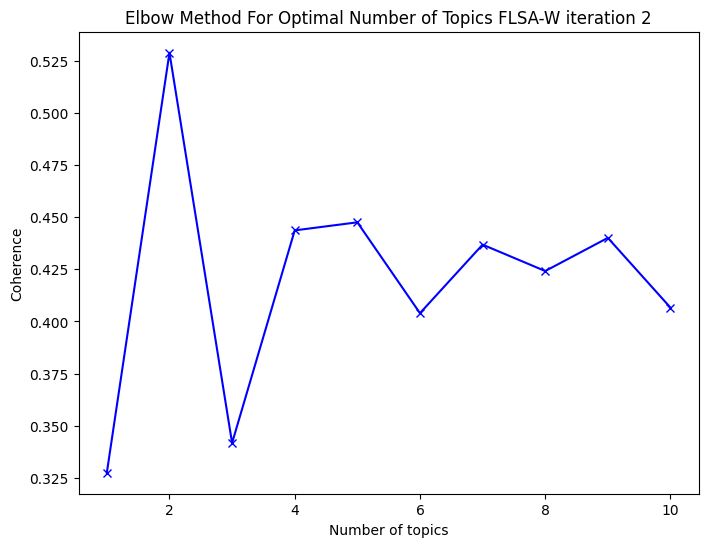

In [48]:
#elbow plot for FLSA-W
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    #train model
    print(n_topics)
    flsaW_elbow = FLSA_W(
    input_file = nvidia_df['content'].to_list(),
    num_topics=n_topics,
    num_words=10,
    )
    flsaW_elbow.get_vocabulary_size()
    pwgt, ptgd = flsaW_elbow.get_matrices() # THIS TRAINS THE MODEL
    #get coherence
    coherence = flsaW_elbow.get_coherence_score()
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics FLSA-W iteration 2')
plt.show()


1
2
3
4
5
6
7
8
9
10


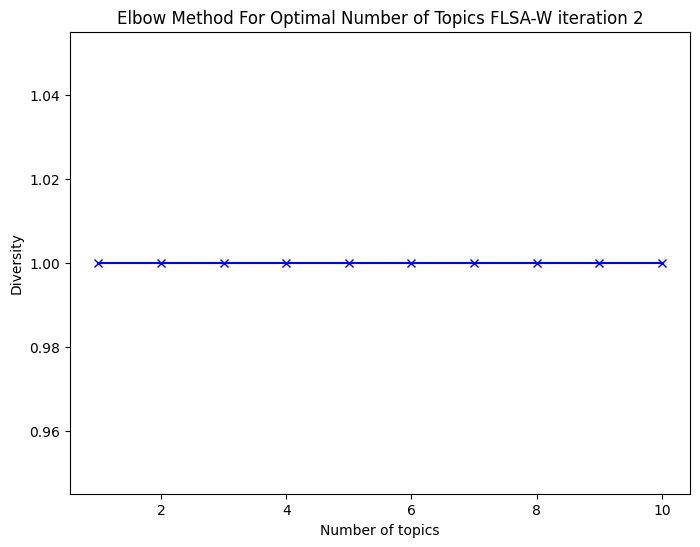

In [49]:
#elbow plot for diversity

#elbow plot for FLSA-W
range_n_topics = range(1, 11)

# Create a list of diversity values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    flsaW_elbow = FLSA_W(
    input_file = nvidia_df['content'].to_list(),
    num_topics=n_topics,
    num_words=10,
    )
    flsaW_elbow.get_vocabulary_size()
    pwgt, ptgd = flsaW_elbow.get_matrices() # THIS TRAINS THE MODEL
    #get diversity
    diversity = flsaW_elbow.get_diversity_score()
    diversities.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, diversities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics FLSA-W iteration 2')
plt.show()


1
2
3
4
5
6
7
8
9
10


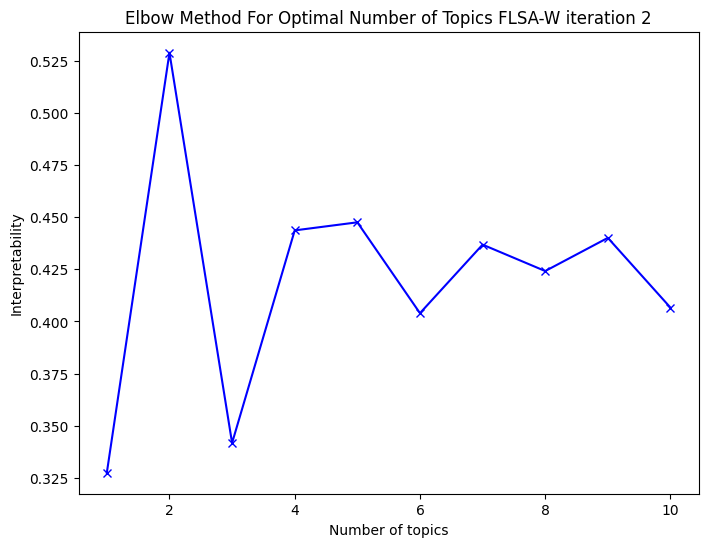

In [50]:
#elbow plot for interpretability
range_n_topics = range(1, 11)
#elbow plot for FLSA-W
interpretabilities = []
for i in range_n_topics:
    print(i)
    interpretability =  coherences[i-1]*diversities[i-1]
    interpretabilities.append(interpretability)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, interpretabilities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Interpretability')
plt.title('Elbow Method For Optimal Number of Topics FLSA-W iteration 2')
plt.show()

## LDA

1
2
3
4
5
6
7
8
9
10


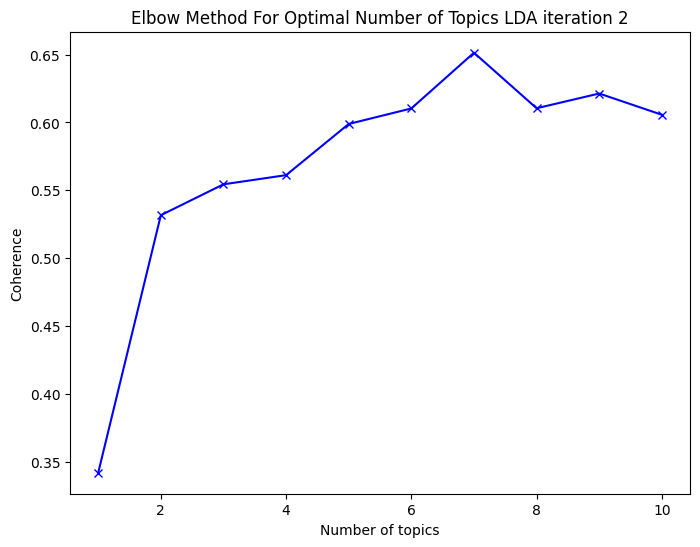

In [51]:
#elbow plot for coherence

#elbow plot for LDA
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(X)
    #get coherence
    topics = get_topics(lda, vectorizer, 10)

    coherence = flsaW.get_coherence_score(
    nvidia_df['content'].to_list(),
    topics)
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics LDA iteration 2')
plt.show()


1
2
3
4
5
6
7
8
9
10


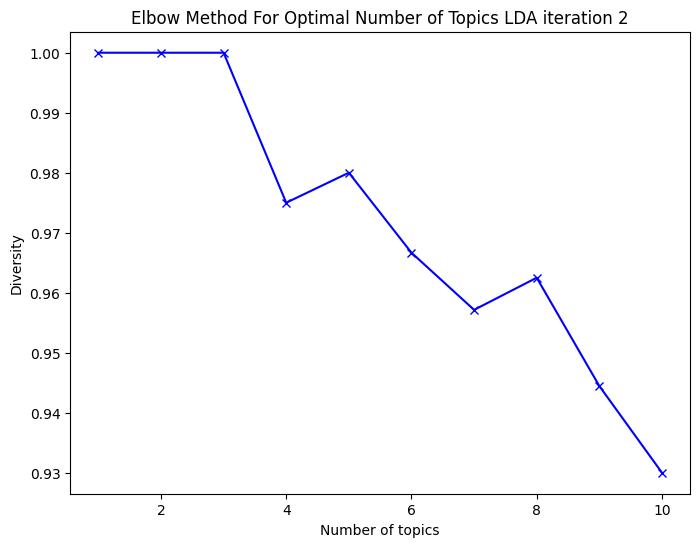

In [52]:
#elbow plot for diversity

#elbow plot for LDA
range_n_topics = range(1, 11)

# Create a list of diversity values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(X)
    #get diversity
    topics = get_topics(lda, vectorizer, 10)

    diversity = flsaW.get_diversity_score(
    
    topics)
    diversities.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, diversities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics LDA iteration 2')
plt.show()

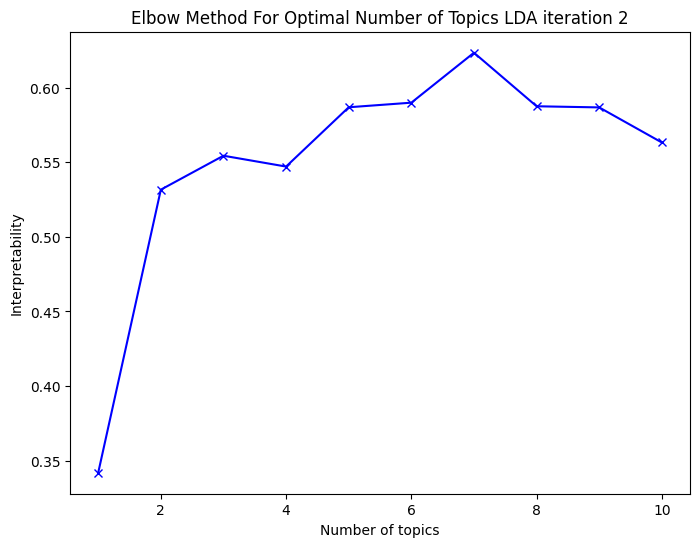

In [53]:
#elbow plot for interpretability

#elbow plot for LDA
interpretabilities = []
for i in range_n_topics:
    interpretability = coherences[i-1] * diversities[i-1]
    interpretabilities.append(interpretability)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, interpretabilities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Interpretability')
plt.title('Elbow Method For Optimal Number of Topics LDA iteration 2')
plt.show()

They remain stable. It would be interesting to write a discussion. (there is little variation why?)

## Bert Topic

In [54]:
from bertopic import BERTopic
from umap import UMAP
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=0)
docs = [' '.join(doc) for doc in nvidia_df['content']]
# Create the model (uses DistilBERT by default)
bert_topic = BERTopic(umap_model=umap_model)
# Train the model and transform your data into topics
topic_assigned_to_doc, _ = bert_topic.fit_transform(docs)
topic_matrix = bert_topic.get_topic_info()
bert_topic.get_topics()



{-1: [('current', 0.005463694762863425),
  ('percent', 0.005261859778967391),
  ('past', 0.005166860648712543),
  ('device', 0.004916835820325913),
  ('long', 0.004742695783198531),
  ('two', 0.004710267754509344),
  ('performance', 0.004692029241908848),
  ('average', 0.004679729966483138),
  ('since', 0.004678849179657952),
  ('today', 0.004672987177431327)],
 0: [('cent', 0.01704037285858846),
  ('gaap', 0.01432668756294096),
  ('cash', 0.014125923495160087),
  ('surprise', 0.013921725622169097),
  ('margin', 0.013517251252848238),
  ('range', 0.013159787906045176),
  ('increased', 0.01290611023183293),
  ('esp', 0.012660832344322475),
  ('reported', 0.01215605755204648),
  ('positive', 0.01192071720792375)],
 1: [('driving', 0.04395529315698502),
  ('car', 0.04179418915053901),
  ('vehicle', 0.041180673113575574),
  ('self', 0.03946205465495944),
  ('autonomous', 0.03415954051861491),
  ('tesla', 0.022525123891450335),
  ('system', 0.01696852116487373),
  ('automotive', 0.015821173

In [55]:
print(topic_matrix)

    Topic  Count                                  Name  \
0      -1   1068        -1_current_percent_past_device   
1       0    199             0_cent_gaap_cash_surprise   
2       1    161            1_driving_car_vehicle_self   
3       2    117              2_etf_fund_exposure_read   
4       3     97     3_resistance_around_towards_break   
..    ...    ...                                   ...   
67     66     13           66_netapp_cloud_flash_array   
68     67     13  67_forecast_versus_production_retail   
69     68     12            68_traded_gmt_seven_lowest   
70     69     11          69_greece_bank_euro_european   
71     70     10       70_nike_apparel_lilly_nordstrom   

                                       Representation  \
0   [current, percent, past, device, long, two, pe...   
1   [cent, gaap, cash, surprise, margin, range, in...   
2   [driving, car, vehicle, self, autonomous, tesl...   
3   [etf, fund, exposure, read, fee, asset, holdin...   
4   [resistance, a

In [56]:
bert_topic.visualize_heatmap(n_clusters=15)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>Similarity Score: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'x': [0_cent_gaap_cash, 2_etf_fund_exposure, 8_gaming_gpus_gpu,
                    10_micron_dram_mu, 29_datacenter_graphic_gaming,
                    62_applied_material_amat, 65_broadcom_avgo_amgen,
                    1_driving_car_vehicle, 54_baidu_apollo_driving,
                    3_resistance_around_towards, 11_trading_call_vix,
                    13_percent_yield_dollar, 14_dow_trump_boeing,
                    31_point_wall_street, 50_dow_closed_jones,
                    4_ai_learning_machine, 22_storage_pure_western,
                    27_mellanox_ethernet_switch, 39_microsoft_google_azure,
                    46_qualcomm_nxp_broadcom, 66_netapp_cloud_flash,
                    5_radeon_graphic_gpu, 32_processor_supercomputer_...,
                    55_game_stadium_gaming, 59_cadence_design_verificat...,
                    6_target_rating_reiterates, 20_corporation_swing_therap...,
                    34_premarket_tesla_gmt, 70_nike_apparel_lilly,
                    7_tracey_podcast_value, 16_projected_climb_roughly,
                    18_portfolio_today_editor, 41_illumina_missed_biotech,
                    52_cap_small_mega, 61_gaming_demand_center,
                    9_close_performer_settle, 12_walmart_retailer_wmt,
                    15_tariff_trump_chinese, 25_oil_crude_energy,
                    33_future_et_point, 36_coronavirus_virus_outbreak,
                    47_brexit_bank_vote, 57_inflation_fed_bank,
                    67_forecast_versus_production, 17_facebook_user_ad,
                    23_huawei_chinese_hikvision, 28_iphone_india_ipad,
                    42_netflix_streaming_original, 45_tsmc_chang_manufacturing,
                    60_softbank_vision_fund, 63_game_esports_activision,
                    19_mining_cryptocurrency_cr..., 38_bitcoin_currency_cryptoc...,
                    21_traded_gmt_seven, 24_traded_gmt_seven, 30_traded_gmt_seven,
                    40_traded_gmt_seven, 48_traded_gmt_seven, 53_traded_gmt_seven,
                    68_traded_gmt_seven, 26_remarkably_obligation_ye...,
                    44_instrument_texas_ti, 49_surprise_beat_esp,
                    56_tripadvisor_hotel_pricel..., 58_ratio_peg_value,
                    64_period_member_eps, 35_qualcomm_patent_commission,
                    37_scenario_oil_target, 43_italy_rallied_soared,
                    69_greece_bank_euro, 51_eps_beat_com],
              'xaxis': 'x',
              'y': [0_cent_gaap_cash, 2_etf_fund_exposure, 8_gaming_gpus_gpu,
                    10_micron_dram_mu, 29_datacenter_graphic_gaming,
                    62_applied_material_amat, 65_broadcom_avgo_amgen,
                    1_driving_car_vehicle, 54_baidu_apollo_driving,
                    3_resistance_around_towards, 11_trading_call_vix,
                    13_percent_yield_dollar, 14_dow_trump_boeing,
                    31_point_wall_street, 50_dow_closed_jones,
                    4_ai_learning_machine, 22_storage_pure_western,
                    27_mellanox_ethernet_switch, 39_microsoft_google_azure,
                    46_qualcomm_nxp_broadcom, 66_netapp_cloud_flash,
                    5_radeon_graphic_gpu, 32_processor_supercomputer_...,
                    55_game_stadium_gaming, 59_cadence_design_verificat...,
                    6_target_rating_reiterates, 20_corporation_swing_therap...,
                    34_premarket_tesla_gmt, 70_nike_apparel_lilly,
                    7_tracey_podcast_value, 16_projected_climb_roughly,
                    18_portfolio_today_editor, 41_illumina_missed_biotech,
                    52_cap_small_mega, 61_gaming_demand_center,
                    9_close_performer_settle, 12_walmart_retailer_wmt,
                    15_tariff_trump_chinese, 25_oil_crude_

In [57]:
topic_matrix.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1068,-1_current_percent_past_device,"[current, percent, past, device, long, two, pe...",[fresh hot menu assess netflix morgan stanley ...
1,0,199,0_cent_gaap_cash_surprise,"[cent, gaap, cash, surprise, margin, range, in...",[lam lrcx lam corporation lrcx reported fiscal...
2,1,161,1_driving_car_vehicle_self,"[driving, car, vehicle, self, autonomous, tesl...",[challenge self driving car space corporation ...
3,2,117,2_etf_fund_exposure_read,"[etf, fund, exposure, read, fee, asset, holdin...",[etf focus closing bell yesterday reported str...
4,3,97,3_resistance_around_towards_break,"[resistance, around, towards, break, roku, sup...",[prediction g bullish spy going try pick left ...
5,4,73,4_ai_learning_machine_intelligence,"[ai, learning, machine, intelligence, ml, arti...",[fast growing ai win big artificial intelligen...
6,5,69,5_radeon_graphic_gpu_card,"[radeon, graphic, gpu, card, gaming, processor...",[boost gaming experience radeon graphic card a...
7,6,69,6_target_rating_reiterates_rbc,"[target, rating, reiterates, rbc, raise, previ...",[jefferies increase target jefferies raise tar...
8,7,63,7_tracey_podcast_value_episode,"[tracey, podcast, value, episode, ryniec, stra...",[value highlight micron applied material lam i...
9,8,60,8_gaming_gpus_gpu_fiscal,"[gaming, gpus, gpu, fiscal, gaap, non, geforce...",[since gone since added frame outperforming re...


In [58]:
# print the name of the topic matrix and the representative docs using for loop
for i in range(0, 11):
    print(topic_matrix['Name'][i])
    print(topic_matrix['Representative_Docs'][i])
    print('')

-1_current_percent_past_device
['fresh hot menu assess netflix morgan stanley wednesday open wall street took slightly green early wednesday another bag hot fresh morgan stanley latest got early thumb netflix nflx appeared get thumb morgan stanley m became latest big bank early wednesday news looked pretty good standpoint beating expectation thing consider however even though outpaced third party m saw profit fall cited slow trading environment matter m firm taken trading recent relies trading many competitor despite m jumped pre trading potentially help underpin financials tuesday big flow going slow slightly toward end morning deluge included abbott laboratory abt pepsico pep tomorrow brings morris union pacific unp thing tail friday holiday next look big though boeing ba microsoft msft among highlight ba call next wednesday anticipated season many await clarity max situation pepsico pep looked relatively got lift pre trading carried lay growing ago chinese fortune improve tenth perc

In [59]:
#create a list of the first 10 representative docs
rep_docs = topic_matrix['Representation'][1:10].to_list()
print(rep_docs)




[['cent', 'gaap', 'cash', 'surprise', 'margin', 'range', 'increased', 'esp', 'reported', 'positive'], ['driving', 'car', 'vehicle', 'self', 'autonomous', 'tesla', 'system', 'automotive', 'mobileye', 'automaker'], ['etf', 'fund', 'exposure', 'read', 'fee', 'asset', 'holding', 'charge', 'score', 'basket'], ['resistance', 'around', 'towards', 'break', 'roku', 'support', 'level', 'rise', 'gap', 'jd'], ['ai', 'learning', 'machine', 'intelligence', 'ml', 'artificial', 'cloud', 'deep', 'inference', 'ibm'], ['radeon', 'graphic', 'gpu', 'card', 'gaming', 'processor', 'ryzen', 'rx', 'rtx', 'ray'], ['target', 'rating', 'reiterates', 'rbc', 'raise', 'previously', 'upside', 'read', 'center', 'gaming'], ['tracey', 'podcast', 'value', 'episode', 'ryniec', 'strategist', 'book', 'investing', 'joined', 'discus'], ['gaming', 'gpus', 'gpu', 'fiscal', 'gaap', 'non', 'geforce', 'ai', 'sequentially', 'platform']]


In [60]:
#bert coherence --> just say we tried, in the end it doesn't matter I tried hard and got so far 
print(
flsaW.get_coherence_score(
nvidia_df['content'].to_list(),
rep_docs[0:4])
)



0.7718401414051339


In [61]:
#bert diversity
print(flsaW.get_diversity_score(rep_docs[0:4]))

1.0


1
2
3
4
5
6
7
8
9
10


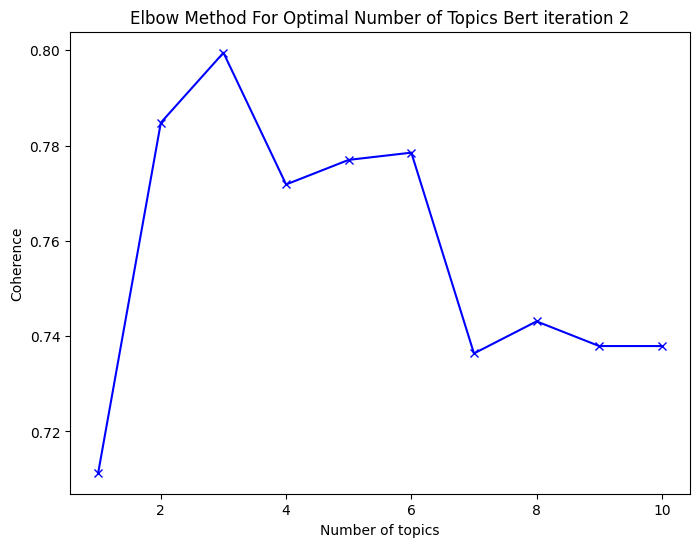

In [62]:
#elbow plot for coherence

#elbow plot for Bert
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    print(n_topics)
    #get coherence
    coherence = flsaW.get_coherence_score(
    nvidia_df['content'].to_list(),
    rep_docs[0:n_topics])
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics Bert iteration 2')
plt.show()


topic

1
2
3
4
5
6
7
8
9
10


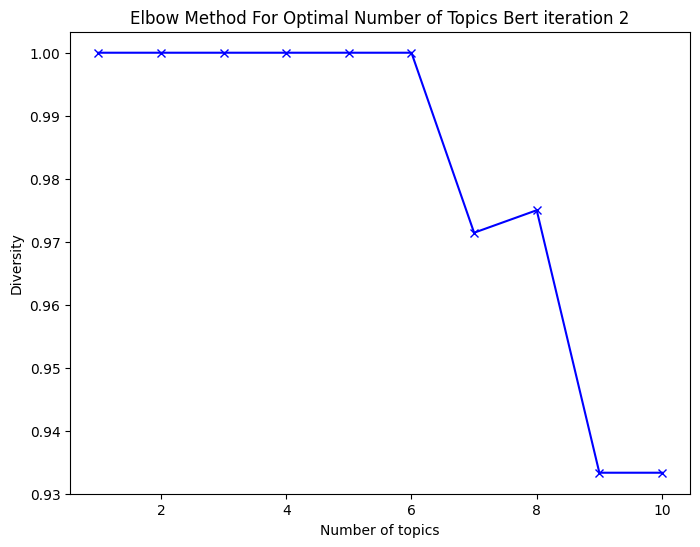

In [63]:
#elbow plot for diversity

#elbow plot for Bert
range_n_topics = range(1, 11)

# Create a list of diversity values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    #get diversity
    diversity = flsaW.get_diversity_score(rep_docs[0:n_topics])
    diversities.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, diversities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics Bert iteration 2')
plt.show()

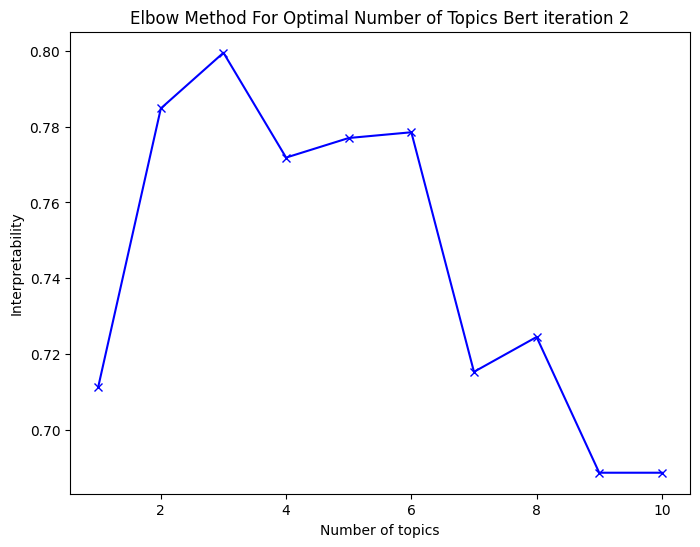

In [64]:
#elbow plot for interpretability

#elbow plot for LDA
interpretabilities = []
for i in range_n_topics:
    interpretability = coherences[i-1] * diversities[i-1]
    interpretabilities.append(interpretability)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, interpretabilities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Interpretability')
plt.title('Elbow Method For Optimal Number of Topics Bert iteration 2')
plt.show()